In [1]:
!nrnivmodl /home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod
from neuron import h
import plotly.graph_objects as go
import matplotlib.colors as mcolors
from neuron.units import ms, mV
import plotly.io as pio
from matplotlib import pyplot, cm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
# 自定义刻度标签显示格式

from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return f'{value:.0f}'  # 将刻度值格式化为小数点后两位

def plot_curve(ax2,x,y,color='black',title='', linestyle='-',xlim=[0,100],dx=20,
               ylim=[0,10],dy=5.0, fontsize=10, alpha = 1.0, xlabel='Time/ms', 
               ylabel = 'Frequency/Hz', label='',ynum_decimals =1, 
               nonscatter=True, s0=10):
    if nonscatter:
        if color:
            ax2.plot(x,y,color=color,linewidth=2,linestyle=linestyle,alpha=alpha, label=label)
        else:
            ax2.plot(x,y,linewidth=2,alpha=alpha, linestyle=linestyle,label=label)
    else:
        if color:
            ax2.scatter(x,y,color=color,linewidth=2,linestyle=linestyle,alpha=alpha, 
                        label=label, s=s0)
        else:
            ax2.scatter(x,y,linewidth=2,alpha=alpha, linestyle=linestyle,label=label,
                        s=s0)
        
    ax2.set_xlabel(xlabel,font2)
    ax2.set_ylabel(ylabel,font2)
    
    # def format_funcx(value, tick_number, num_decimals=xnum_decimals):
    #     if num_decimals==0:
    #         return f'{value:.0f}'
    #     return f'{value:.{num_decimals}f}'

    def format_funcy(value, tick_number, num_decimals=ynum_decimals):
        if num_decimals==0:
          return f'{value:.0f}'
        return f'{value:.{num_decimals}f}'

    # if dx:
    #     ax2.set_xticks(np.arange(xlim[0], xlim[1] + dx, dx))
    #     ax2.set_xticklabels(ax2.get_xticks(), fontsize=fontsize, weight='bold')
    #     ax2.set_xlim([xlim[0], xlim[1]])
    #     ax2.xaxis.set_major_formatter(FuncFormatter(format_funcx))

    if dy:
        ax2.set_yticks(np.arange(ylim[0], ylim[1] + dy, dy))
        ax2.set_yticklabels(ax2.get_yticks(), fontsize=fontsize, weight='bold')
        ax2.set_ylim([ylim[0], ylim[1]])
        ax2.yaxis.set_major_formatter(FuncFormatter(format_funcy))
        
  
    if xlim:
       ax2.set_xticks(np.arange(xlim[0],xlim[1]+dx,dx))
       ax2.set_xticklabels(np.arange(xlim[0],xlim[1]+dx,dx),fontsize=10,weight='bold')
       ax2.set_xlim(xlim)
    # if ylim:
    #    ax2.set_yticks(np.arange(ylim[0],ylim[1]+dy,dy))
    #    ax2.set_yticklabels(np.arange(ylim[0],ylim[1]+dy,dy),fontsize=10,weight='bold')
    #    ax2.set_ylim(ylim)
    if title:
       ax2.set_title('{0}'.format(title),fontsize=12,weight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    if label:
       ax2.legend(loc='best',prop=font2,edgecolor='white')

def exp_fitting(x,y, num=1):
    
    if num==2:
        # Calculate integrals
        iy1 = cumtrapz(y, x, initial=0)
        iy2 = cumtrapz(iy1, x, initial=0)


        # Get exponentials lambdas
        Y = np.column_stack((iy1, iy2,  x**2, x, np.ones_like(x)))
        A = pinv(Y) @ y

        lambdas = eig(np.array([[A[0], A[1]], [1, 0]]))[0]
        # print("Lambdas:", lambdas)

        # Get exponentials multipliers
        X = np.column_stack((np.ones_like(x), np.exp(lambdas[0] * x), np.exp(lambdas[1] * x)))
        P = pinv(X) @ y
        # print("Multipliers:", P)
    
    if num==1:
        iy1 = cumtrapz(y, x, initial=0)

        # Get exponentials lambdas
        Y = np.column_stack((iy1, x, np.ones_like(x)))
        A = pinv(Y) @ y

        lambdas = A[0]
        # print("Lambdas:", lambdas)


        # Get exponentials multipliers
        X = np.column_stack((np.ones_like(x), np.exp(lambdas * x)))
        P = pinv(X) @ y
        # print("Multipliers:", P)
    
    return lambdas, P
h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/morphologies/cell1.asc"
biophysicalModelFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCbiophys1.hoc"
biophysicalModelTemplateFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCtemplate.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)


def time_constant_fitting(run_dt, dtime, fE, passive=False, E = True, loc=58,
                          block='',name= '', location ='dend', 
                          setIh = False, gIhbar_Ih = 0.):
    
    L5PC = h.L5PCtemplate(morphologyFilename)

    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    if setIh:
        for sec in h.allsec():
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = gIhbar_Ih
             
    # Set simulation parameters
    h.dt = run_dt
    h.tstop = 200.
    h.v_init = -77.
    v_clamp = -77.


    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()

    # attach it to a synapse
    if location == 'dend':
        syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))
    if location == 'apic':
        syn = h.Exp2Syn(L5PC.apic[int(loc)](0.9))
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        syn.e = 0.  # mV for E input and -80 for I input
    else: 
        syn.e = -80.
    # print(syn.e)
        
    stim.number = 1
    stim.start = 100.  # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = 0e-2  # uS


    # Initialize voltage clamp
    vclamp = h.SEClamp(L5PC.soma[0](0.5))
    vclamp.amp1 = v_clamp
    vclamp.dur2 = h.tstop
    vclamp.amp2 = v_clamp - 20.

    irec = h.Vector()
    irec.record(vclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
        # vol = h.Vector()
    
        # savdata = open("neuron_voltage.dat", "w")
        T = 200./run_dt+1
        N = int(10./dtime)
        data = np.zeros((2*N, int(T)))


        for i in range(1, N+1):
            vclamp.dur1 = 100. + i * dtime

            ncstim.weight[0] = 0e-2
            go()
            # data[4*(i-1),:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1),:] = irec.to_python()  # Assuming irec is a NEURON Vector

            
            ncstim.weight[0] = fE
            go()
            # data[4*(i-1)+2,:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1)+1,:] = irec.to_python()  # Assuming irec is a NEURON Vector

        # np.savetxt("neuron_voltage.txt", data)
        # print("Done data!")
        I_w_ng = data[::2, :]
        I_w_g = data[1::2, :]
        diff_I = I_w_ng - I_w_g
        x = np.arange(0.1, 10.1, dtime) # ms
        y = -np.sum(diff_I, axis=1)  # size of 100

        result_lambdas, result_multipliers = exp_fitting(x, y, num=2)
        # ground_truth = np.array([-1., -0.2])
        # relative_error = np.abs((result_lambdas - ground_truth)/ground_truth)
        return result_lambdas, y
    
    
    result_lambdas, y = main()
    return result_lambdas, y
    

/home/wzl/anaconda/envs/neuron9/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO : Using neuron-nightly Package (Developer Version)
/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron
cfiles =
Mod files: "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/CaDynamics_E2.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_HVA.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_LVAst.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/epsp.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ih.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Im.mod" "/home/wzl/LFPy/project/conductance_measurement/real

--No graphics will be displayed.


In [ ]:
L5PC = h.L5PCtemplate(morphologyFilename)
L5PC.soma[0].psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [3.44e-05], 'e': [-90.0], 'i': [0.0]},
  'CaDynamics_E2': {'gamma': [0.000549],
   'decay': [486.0],
   'depth': [0.1],
   'minCai': [0.0001]},
  'Ca_HVA': {'gCa_HVAbar': [0.000567],
   'ica': [0.0],
   'gCa_HVA': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'Ca_LVAst': {'gCa_LVAstbar': [0.00432],
   'ica': [0.0],
   'gCa_LVAst': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'Ih': {'gIhbar': [0.0002],
   'ehcn': [-45.0],
   'ihcn': [0.0],
   'gIh': [0.0],
   'm': [0.0]},
  'K_Pst': {'gK_Pstbar': [0.000547],
   'ik': [0.0],
   'gK_Pst': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'K_Tst': {'gK_Tstbar': [0.0326],
   'ik': [0.0],
   'gK_Tst': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'Nap_Et2': {'gNap_Et2bar': [0.00496],
   'ina': [0.0],
   'gNap_Et2': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'NaTa_t': {'gNaTa_tbar': [1.71],
   'ina': [0.0],
   'gNaTa_t': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'SK_E2': {'gSK_E2bar': [0.0556], 'ik': [0.0], 'gSK_E2': [

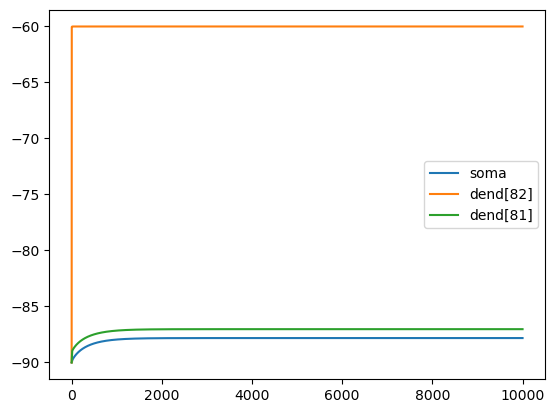

In [2]:
L5PC = h.L5PCtemplate(morphologyFilename)
for sec in h.allsec():
    # 检查 section 是否有主动离子通道
    if h.ismembrane("na3", sec=sec):
        # 将电导设置为0
        sec.gbar_na3 = 0.
    if h.ismembrane("h", sec=sec):
        sec.ghdbar_h = 0.
    if h.ismembrane("kadist", sec=sec):
        sec.gkabar_kadist = 0.
    if h.ismembrane("kaprox", sec=sec):
        sec.gkabar_kaprox = 0.
    if h.ismembrane("kdrca1", sec=sec):
        sec.gkdrbar_kdrca1 = 0.
    if h.ismembrane("nax", sec=sec):
        sec.gbar_nax = 0.
    if h.ismembrane("Ca_HVA",sec=sec):
        sec.gCa_HVAbar_Ca_HVA = 0.
    if h.ismembrane("Ca_LVAst",sec=sec):
        sec.gCa_LVAstbar_Ca_LVAst = 0.
    if h.ismembrane("Ih",sec=sec):
        # sec.gIhbar_Ih = 0.0002/20
        sec.gIhbar_Ih = 0.0
    if h.ismembrane("Im",sec=sec):
        sec.gImbar_Im = 0.
    if h.ismembrane("K_Pst",sec=sec):
        sec.gK_Pstbar_K_Pst = 0.
    if h.ismembrane("K_Tst",sec=sec):
        sec.gK_Tstbar_K_Tst = 0.
    if h.ismembrane("Nap_Et2",sec=sec):
        sec.gNap_Et2bar_Nap_Et2 = 0.
    if h.ismembrane("NaTa_t",sec=sec):
        sec.gNaTa_tbar_NaTa_t = 0.
    if h.ismembrane("NaTs2_t",sec=sec):
        sec.gNaTs2_tbar_NaTs2_t = 0.
    if h.ismembrane("SK_E2",sec=sec):
        sec.gSK_E2bar_SK_E2 = 0.
    if h.ismembrane("SKv3_1",sec=sec):
        sec.gSKv3_1bar_SKv3_1 = 0.  
# Set simulation parameters
h.dt = 0.1
h.tstop = 1000.
# passive
h.v_init = -90.
v_clamp = -60.


# # active
# h.v_init = -88.
# v_clamp = -55.

recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
v_dend82 = h.Vector().record(L5PC.dend[82](0.5)._ref_v)
v_dend81 = h.Vector().record(L5PC.dend[81](0.5)._ref_v)
 
# Initialize voltage clamp
vclamp = h.SEClamp(L5PC.dend[82](0.5))
vclamp.amp1 = v_clamp
vclamp.dur1 = h.tstop
vclamp.dur2 = h.tstop
vclamp.amp2 = v_clamp
vclamp.amp3 = v_clamp

irec = h.Vector()
irec.record(vclamp._ref_i)

h.t = 0
h.finitialize(h.v_init)
h.fcurrent()


while h.t < h.tstop:
    h.fadvance()

plt.plot(recv, label='soma')
plt.plot(v_dend82, label = 'dend[82]')
plt.plot(v_dend81, label = 'dend[81]')
plt.legend()


In [26]:
Gamma_ES = (v_dend82[-1] + 90.)/irec[-1]
print(v_dend82[-1])
print(irec[-1])
print(Gamma_ES)

-61.98049732515718
0.34885122881239283
80.31934635927942


In [28]:
Gamma_SE = (recv[-1] + 90.)/irec[-1]
print(recv[-1])
print(irec[-1])
print(Gamma_SE)

-87.8217178316383
0.027120267620666993
80.31934635857888


In [32]:
80.31934635857888/80.31934635927942

0.9999999999912781

In [33]:
for sec in h.allsec():
    print(sec)

L5PCtemplate[8].soma[0]
L5PCtemplate[8].dend[0]
L5PCtemplate[8].dend[1]
L5PCtemplate[8].dend[2]
L5PCtemplate[8].dend[3]
L5PCtemplate[8].dend[4]
L5PCtemplate[8].dend[5]
L5PCtemplate[8].dend[6]
L5PCtemplate[8].dend[7]
L5PCtemplate[8].dend[8]
L5PCtemplate[8].dend[9]
L5PCtemplate[8].dend[10]
L5PCtemplate[8].dend[11]
L5PCtemplate[8].dend[12]
L5PCtemplate[8].dend[13]
L5PCtemplate[8].dend[14]
L5PCtemplate[8].dend[15]
L5PCtemplate[8].dend[16]
L5PCtemplate[8].dend[17]
L5PCtemplate[8].dend[18]
L5PCtemplate[8].dend[19]
L5PCtemplate[8].dend[20]
L5PCtemplate[8].dend[21]
L5PCtemplate[8].dend[22]
L5PCtemplate[8].dend[23]
L5PCtemplate[8].dend[24]
L5PCtemplate[8].dend[25]
L5PCtemplate[8].dend[26]
L5PCtemplate[8].dend[27]
L5PCtemplate[8].dend[28]
L5PCtemplate[8].dend[29]
L5PCtemplate[8].dend[30]
L5PCtemplate[8].dend[31]
L5PCtemplate[8].dend[32]
L5PCtemplate[8].dend[33]
L5PCtemplate[8].dend[34]
L5PCtemplate[8].dend[35]
L5PCtemplate[8].dend[36]
L5PCtemplate[8].dend[37]
L5PCtemplate[8].dend[38]
L5PCtemplat

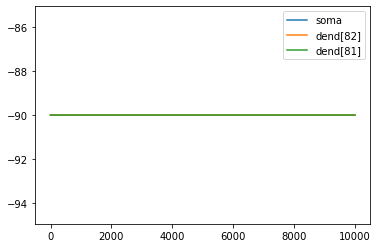

In [16]:
L5PC = h.L5PCtemplate(morphologyFilename)
for sec in h.allsec():
    # 检查 section 是否有主动离子通道
    if h.ismembrane("na3", sec=sec):
        # 将电导设置为0
        sec.gbar_na3 = 0.
    if h.ismembrane("h", sec=sec):
        sec.ghdbar_h = 0.
    if h.ismembrane("kadist", sec=sec):
        sec.gkabar_kadist = 0.
    if h.ismembrane("kaprox", sec=sec):
        sec.gkabar_kaprox = 0.
    if h.ismembrane("kdrca1", sec=sec):
        sec.gkdrbar_kdrca1 = 0.
    if h.ismembrane("nax", sec=sec):
        sec.gbar_nax = 0.
    if h.ismembrane("Ca_HVA",sec=sec):
        sec.gCa_HVAbar_Ca_HVA = 0.
    if h.ismembrane("Ca_LVAst",sec=sec):
        sec.gCa_LVAstbar_Ca_LVAst = 0.
    if h.ismembrane("Ih",sec=sec):
        # sec.gIhbar_Ih = 0.0002/20
        sec.gIhbar_Ih = 0.0
    if h.ismembrane("Im",sec=sec):
        sec.gImbar_Im = 0.
    if h.ismembrane("K_Pst",sec=sec):
        sec.gK_Pstbar_K_Pst = 0.
    if h.ismembrane("K_Tst",sec=sec):
        sec.gK_Tstbar_K_Tst = 0.
    if h.ismembrane("Nap_Et2",sec=sec):
        sec.gNap_Et2bar_Nap_Et2 = 0.
    if h.ismembrane("NaTa_t",sec=sec):
        sec.gNaTa_tbar_NaTa_t = 0.
    if h.ismembrane("NaTs2_t",sec=sec):
        sec.gNaTs2_tbar_NaTs2_t = 0.
    if h.ismembrane("SK_E2",sec=sec):
        sec.gSK_E2bar_SK_E2 = 0.
    if h.ismembrane("SKv3_1",sec=sec):
        sec.gSKv3_1bar_SKv3_1 = 0.  
# Set simulation parameters
h.dt = 0.1
h.tstop = 1000.
# passive
h.v_init = -90.
v_clamp = -60.


# # active
# h.v_init = -88.
# v_clamp = -55.

recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
v_dend82 = h.Vector().record(L5PC.dend[82](0.5)._ref_v)
v_dend81 = h.Vector().record(L5PC.dend[81](0.5)._ref_v)
 
# Initialize voltage clamp
# vclamp = h.SEClamp(L5PC.soma[0](0.5))
# vclamp.amp1 = v_clamp
# vclamp.dur1 = h.tstop
# vclamp.dur2 = h.tstop
# vclamp.amp2 = v_clamp
# vclamp.amp3 = v_clamp

# irec = h.Vector()
# irec.record(vclamp._ref_i)

h.t = 0
h.finitialize(h.v_init)
h.fcurrent()


while h.t < h.tstop:
    h.fadvance()

plt.plot(recv, label='soma')
plt.plot(v_dend82, label = 'dend[82]')
plt.plot(v_dend81, label = 'dend[81]')
plt.legend()


In [4]:
from neuron import h
import plotly.graph_objects as go
import matplotlib.colors as mcolors
from neuron.units import ms, mV
import plotly.io as pio
from matplotlib import pyplot, cm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}

In [3]:
ratio_KSE_KES = np.loadtxt('ratio_KSE_KES.txt')
i = 0
for sec in h.allsec():
    for seg in sec:
        seg.v = ratio_KSE_KES[i]
    i = i + 1

In [4]:
cmap=cm.jet
v_vals = [seg.v for sec in h.allsec() for seg in sec]
minv = min(v_vals)
maxv = max(v_vals)
print(minv, maxv)

0.8693887079973818 1.000000000033836


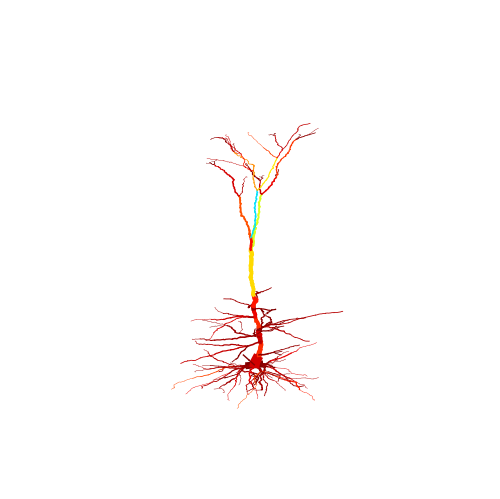

In [8]:
cmap=cm.jet
v_vals = [seg.v for sec in h.allsec() for seg in sec]
# minv = min(v_vals)
# maxv = max(v_vals)
minv = 0.8
maxv = 1.0
# colorbarlabel = 'V/mV'
# ticklabels = True
# tickmin = -90.
# tickmax = -60.
# dt = -20.
# # L5PC = h.L5PCtemplate(morphologyFilename)
L5PC.soma[0].diam = 5.


ps = h.PlotShape(False)  # 创建PlotShape对象
ps.variable('v')
ps.scale(minv, maxv)
ps.show(0)  # 不自动显示NEURON的窗口

# 使用Matplotlib进行绘图
# ax = ps.plot(plt)   
ax = ps.plot(pyplot, cmap=cm.jet)
# # 设置坐标轴范围
ax.set_xlim([-300, 300])  # 设置x轴范围
ax.set_ylim([0, 1400])  # 设置y轴范围
ax.set_zlim([-600, 0])  # 设置z轴范围

# ps.view(-400,0, 0, 300, 0, 300, 100, 500)
ax.view_init(elev=280, azim=98)
ax.grid(False)
# 关闭坐标轴
ax.axis('off')
plt.show()


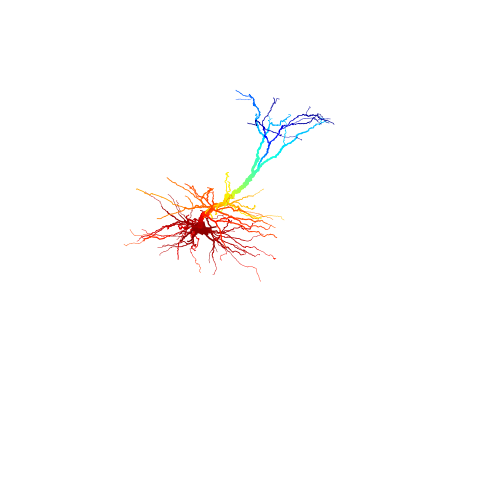

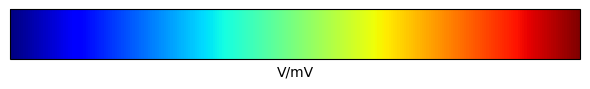

-79.12261856481791 -60.72519925312153


In [58]:
cmap=cm.jet
v_vals = [seg.v for sec in h.allsec() for seg in sec]
minv = min(v_vals)
maxv = max(v_vals)
colorbarlabel = 'V/mV'
ticklabels = True
tickmin = -80.
tickmax = -60.
dt = -20.
# L5PC = h.L5PCtemplate(morphologyFilename)
L5PC.soma[0].diam = 5.

        
ps = h.PlotShape(False)  # False tells h.PlotShape not to use NEURON's gui
ps.variable('v')
ps.scale(minv, maxv)
ps.show(0)
ax = ps.plot(pyplot, cmap=cmap)

# # 设置坐标轴范围
ax.set_xlim([-300, 300])  # 设置x轴范围
ax.set_ylim([0, 1400])  # 设置y轴范围
ax.set_zlim([-600, 0])  # 设置z轴范围

# 关闭网格
ax.grid(False)
# 关闭坐标轴
ax.axis('off')
pyplot.show()




# second figure
ps = h.PlotShape(True)
ps.show(0)
ps.variable("v")
ps.scale(minv, maxv)
fig = ps.plot(plotly, cmap=cmap)



# Create a colormap function
colormap = cm.ScalarMappable(cmap=cmap, 
norm=mcolors.Normalize(vmin=0, vmax=1)).to_rgba

# Map the normalized values to a Plotly colorscale as strings
plotly_colorscale = [[v, f'rgb{tuple(int(255 * c) for c in colormap(v)[:3])}'] for v in np.linspace(0, 1, cmap.N)]

# Create a separate scatter plot for the colorbar
colorbar_trace = go.Scatter(
    x=[0],
    y=[0],
    mode='markers',
    marker=dict(
        colorscale=plotly_colorscale,
        cmin=minv,
        cmax=maxv,
        colorbar=dict(
            title=colorbarlabel,
            thickness=20  # Adjust the thickness of the colorbar
        ),
        showscale=True
    )
)

# Add the colorbar trace to the figure
fig.add_trace(colorbar_trace)
fig.update_xaxes(showticklabels=False, showgrid=True)
fig.update_yaxes(showticklabels=False, showgrid=True)
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()


# 创建自定义的颜色映射
cmap = cmap
colormap = cm.ScalarMappable(cmap=cmap, 
        norm=mcolors.Normalize(vmin=minv, vmax=maxv))

# 创建一个新的图形和轴
fig, ax = plt.subplots(figsize=(6, 1))

# 绘制颜色条
cbar = plt.colorbar(colormap, cax=ax, orientation='horizontal')
cbar.set_label(colorbarlabel)
if ticklabels:
    cbar.set_ticks(np.arange(tickmin, tickmax, dt))
    cbar.set_ticklabels([f'{i}' for i in np.arange(tickmin, tickmax, dt)])

# 设置图的边界
plt.tight_layout()

savefig = False
if savefig:
    # 保存为 EPS 格式
    plt.savefig(figname+'colorbar'+'.eps', format='eps')

# 显示图形（可选）
plt.show()

print(minv,maxv)



In [63]:
i = 0
KE_passive = np.zeros_like(v_rest)
for sec in h.allsec():
    for seg in sec:
        KE_passive[i] = (seg.v - v_rest[i])/(-60. - v_rest[i])
        i = i + 1

np.savetxt('KE_passive.txt', KE_passive)

In [7]:
# diameter
KE_dend = np.zeros(84)
KE_apic = np.zeros(109)
for i in range(len(L5PC.dend)):
    KE_dend[i] = L5PC.dend[i].v
for i in range(len(L5PC.apic)):
    KE_apic[i] = L5PC.apic[i].v
# print(KE_dend)
# print(KE_apic)
np.savetxt('KE_dend.txt', KE_dend)
np.savetxt('KE_apic.txt', KE_apic)

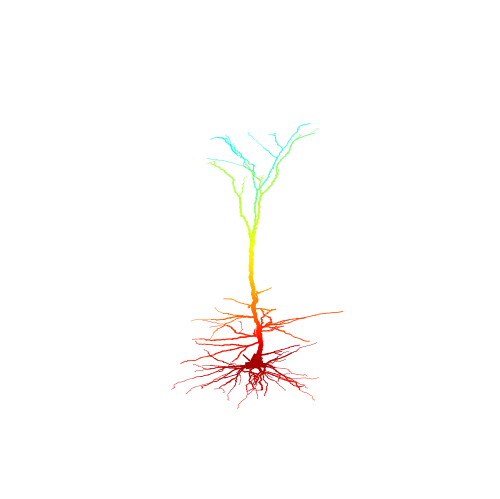

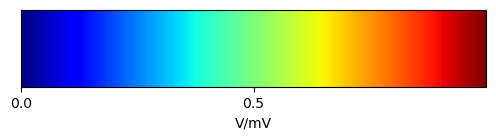

In [64]:
from neuron import h
from matplotlib import pyplot as plt
i = 0
for sec in h.allsec():
    for seg in sec:
        seg.v = (seg.v - v_rest[i])/(-60. - v_rest[i])
        i=i+1
        
cmap=cm.jet
# for sec in h.allsec():
#     for seg in sec:
#         seg.v = (seg.v + 90.)/30.

# v_vals = [seg.v for sec in h.allsec() for seg in sec]
minv = 0.
maxv = 1.
colorbarlabel = 'V/mV'
ticklabels = True
tickmin = 0.
tickmax = 1.
dt = 0.5
# L5PC = h.L5PCtemplate(morphologyFilename)
L5PC.soma[0].diam = 5.

# 绘图设置
ps = h.PlotShape(False)  # 创建PlotShape对象
ps.show(0)  # 不自动显示NEURON的窗口
ps.variable('v')
ps.scale(minv, maxv)

# 使用Matplotlib进行绘图
ax = ps.plot(pyplot, cmap=cmap)

# # 设置坐标轴范围
ax.set_xlim([-300, 300])  # 设置x轴范围
ax.set_ylim([0, 1400])  # 设置y轴范围
ax.set_zlim([-600, 0])  # 设置z轴范围

# ps.view(-400,0, 0, 300, 0, 300, 100, 500)
ax.view_init(elev=280, azim=98)
ax.grid(False)
# 关闭坐标轴
ax.axis('off')
plt.savefig("KE.eps", format='eps', dpi=300)
plt.show()

# 创建自定义的颜色映射
cmap = cmap
colormap = cm.ScalarMappable(cmap=cmap, 
        norm=mcolors.Normalize(vmin=minv, vmax=maxv))

# 创建一个新的图形和轴

fig, ax = plt.subplots(figsize=(6, 1))

# 绘制颜色条
cbar = plt.colorbar(colormap, cax=ax, orientation='horizontal')
cbar.set_label(colorbarlabel)
if ticklabels:
    cbar.set_ticks(np.arange(tickmin, tickmax, dt))
    cbar.set_ticklabels([f'{i}' for i in np.arange(tickmin, tickmax, dt)])

# # 设置图的边界
# plt.tight_layout()


# 显示图形（可选）
plt.show()


In [66]:
KE_passive = np.loadtxt('KE_passive.txt')
KE_active = np.loadtxt('KE_activegIhbar_Ih0_05.txt')
diff = KE_active - KE_passive
i=0
for sec in h.allsec():
    for seg in sec:
        seg.v = diff[i]
        i=i+1
v_vals = [seg.v for sec in h.allsec() for seg in sec]
print(np.min(v_vals), np.max(v_vals))

-0.021563570063172166 0.03755534519847237


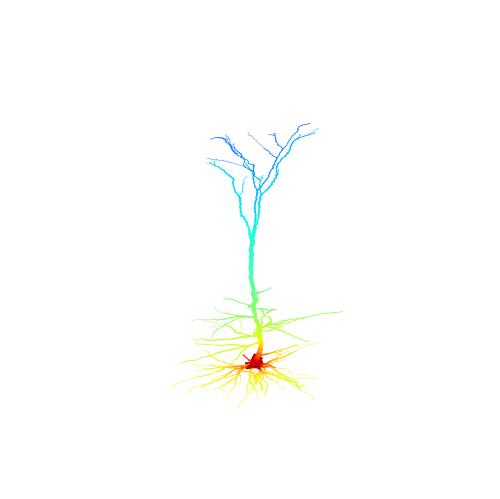

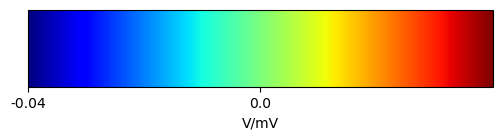

In [69]:

cmap=cm.jet
# for sec in h.allsec():
#     for seg in sec:
#         seg.v = (seg.v + 90.)/30.

# v_vals = [seg.v for sec in h.allsec() for seg in sec]
minv = -0.04
maxv = 0.04
colorbarlabel = 'V/mV'
ticklabels = True
tickmin = -0.04
tickmax = 0.04
dt = 0.04
# L5PC = h.L5PCtemplate(morphologyFilename)
L5PC.soma[0].diam = 5.

# 绘图设置
ps = h.PlotShape(False)  # 创建PlotShape对象
ps.show(0)  # 不自动显示NEURON的窗口
ps.variable('v')
ps.scale(minv, maxv)

# 使用Matplotlib进行绘图
ax = ps.plot(pyplot, cmap=cmap)

# # 设置坐标轴范围
ax.set_xlim([-300, 300])  # 设置x轴范围
ax.set_ylim([0, 1400])  # 设置y轴范围
ax.set_zlim([-600, 0])  # 设置z轴范围

# ps.view(-400,0, 0, 300, 0, 300, 100, 500)
ax.view_init(elev=280, azim=98)
ax.grid(False)
# 关闭坐标轴
ax.axis('off')
# plt.savefig("KE.eps", format='eps', dpi=300)
# plt.show()

# 创建自定义的颜色映射
cmap = cmap
colormap = cm.ScalarMappable(cmap=cmap, 
        norm=mcolors.Normalize(vmin=minv, vmax=maxv))

# 创建一个新的图形和轴

fig, ax = plt.subplots(figsize=(6, 1))

# 绘制颜色条
cbar = plt.colorbar(colormap, cax=ax, orientation='horizontal')
cbar.set_label(colorbarlabel)
if ticklabels:
    cbar.set_ticks(np.arange(tickmin, tickmax, dt))
    cbar.set_ticklabels([f'{i}' for i in np.arange(tickmin, tickmax, dt)])

# # 设置图的边界
# plt.tight_layout()


# 显示图形（可选）
plt.show()


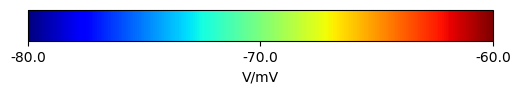

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

cmap=cm.jet
v_vals = [seg.v for sec in h.allsec() for seg in sec]
minv = -80.
maxv = -60.
colorbarlabel = 'V/mV'
ticklabels = True
tickmin, tickmax, dt = minv,maxv, 10  # 定义刻度的起始、结束和间隔

# 创建自定义的颜色映射
colormap = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=minv, vmax=maxv))

# 创建一个新的图形和轴
fig, ax = plt.subplots(figsize=(6, 0.4))

# 绘制颜色条
cbar = plt.colorbar(colormap, cax=ax, orientation='horizontal')
cbar.set_label(colorbarlabel)
cbar.set_ticks(np.arange(tickmin, tickmax+dt, dt))  # 确保包括tickmax
cbar.set_ticklabels([f'{i}' for i in np.arange(tickmin, tickmax+dt, dt)])  # 同上
plt.savefig("/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/figure/space_clamp_error_colorbar.eps", format='eps', dpi=300)

plt.show()


-79.12432735292295 -60.348856319567396


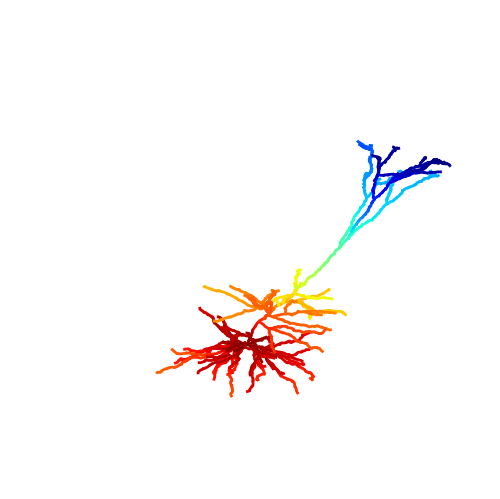

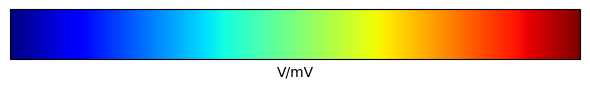

In [8]:
cmap=cm.jet
v_vals = [seg.v for sec in h.allsec() for seg in sec]
minv = min(v_vals)
maxv = max(v_vals)
colorbarlabel = 'V/mV'
ticklabels = True
tickmin = -80.
tickmax = -60.
dt = -5.
print(min(v_vals),max(v_vals))
ps = h.PlotShape(False)  # False tells h.PlotShape not to use NEURON's gui
ps.variable('v')
ps.scale(min(v_vals), max(v_vals))
ax = ps.plot(pyplot, cmap=cmap)
ps.show(1)

# 设置坐标轴范围
ax.set_xlim([-700, 0])  # 替换 xmin 和 xmax 为所需的 x 范围
ax.set_ylim([500, 1400])  # 替换 ymin 和 ymax 为所需的 y 范围
ax.set_zlim([-1000, 00])  # 替换 zmin 和 zmax 为所需的 z 范围
# 关闭网格
ax.grid(False)
# 关闭坐标轴
ax.axis('off')
# 保存为 EPS 格式

# 创建自定义的颜色映射
cmap = cmap
colormap = cm.ScalarMappable(cmap=cmap, 
        norm=mcolors.Normalize(vmin=minv, vmax=maxv))

# 创建一个新的图形和轴
fig, ax = plt.subplots(figsize=(6, 1))

# 绘制颜色条
cbar = plt.colorbar(colormap, cax=ax, orientation='horizontal')
cbar.set_label(colorbarlabel)
if ticklabels:
    cbar.set_ticks(np.arange(tickmin, tickmax, dt))
    cbar.set_ticklabels([f'{i}' for i in np.arange(tickmin, tickmax, dt)])

# 设置图的边界
plt.tight_layout()
savefig = False
if savefig:
    # 保存为 EPS 格式
    plt.savefig(figname+'colorbar'+'.eps', format='eps')

# 显示图形（可选）
plt.show()


In [78]:
result_lambdas, y = time_constant_fitting(0.1, 0.1, 1e-3, passive=True, E = True, loc=38,
                          block='',name= '', location ='dend')
print(result_lambdas)

[-0.62456353 -0.17322934]


In [80]:
x = np.arange(0.1, 10.1, 0.1) # ms
result_lambdas, result_multipliers = exp_fitting(x, y, num=2)
print(result_lambdas)

[-0.62456353 -0.17322934]


In [65]:
L5PC = h.L5PCtemplate(morphologyFilename)
passive = True
if passive:
    for sec in h.allsec():
        # 检查 section 是否有主动离子通道
        if h.ismembrane("na3", sec=sec):
            # 将电导设置为0
            sec.gbar_na3 = 0.
        if h.ismembrane("h", sec=sec):
            sec.ghdbar_h = 0.
        if h.ismembrane("kadist", sec=sec):
            sec.gkabar_kadist = 0.
        if h.ismembrane("kaprox", sec=sec):
            sec.gkabar_kaprox = 0.
        if h.ismembrane("kdrca1", sec=sec):
            sec.gkdrbar_kdrca1 = 0.
        if h.ismembrane("nax", sec=sec):
            sec.gbar_nax = 0.
        if h.ismembrane("Ca_HVA",sec=sec):
            sec.gCa_HVAbar_Ca_HVA = 0.
        if h.ismembrane("Ca_LVAst",sec=sec):
            sec.gCa_LVAstbar_Ca_LVAst = 0.
        if h.ismembrane("Ih",sec=sec):
            sec.gIhbar_Ih = 0.
        if h.ismembrane("Im",sec=sec):
            sec.gImbar_Im = 0.
        if h.ismembrane("K_Pst",sec=sec):
            sec.gK_Pstbar_K_Pst = 0.
        if h.ismembrane("K_Tst",sec=sec):
            sec.gK_Tstbar_K_Tst = 0.
        if h.ismembrane("Nap_Et2",sec=sec):
            sec.gNap_Et2bar_Nap_Et2 = 0.
        if h.ismembrane("NaTa_t",sec=sec):
            sec.gNaTa_tbar_NaTa_t = 0.
        if h.ismembrane("NaTs2_t",sec=sec):
            sec.gNaTs2_tbar_NaTs2_t = 0.
        if h.ismembrane("SK_E2",sec=sec):
            sec.gSK_E2bar_SK_E2 = 0.
        if h.ismembrane("SKv3_1",sec=sec):
            sec.gSKv3_1bar_SKv3_1 = 0.   

h.dt = 0.1
h.tstop = 200.
h.v_init = -77.
v_clamp = -77.


# Initialize an excitatory or inhibitory synaptic input
# make a new stimulator
stim = h.NetStim()


syn = h.Exp2Syn(L5PC.dend[int(38)](0.9))
syn.tau1 = 1.  # ms
syn.tau2 = 5.  # ms
syn.e = 0.  # mV for E input and -80 for I input
    
stim.number = 1
stim.start = 100.  # ms
ncstim = h.NetCon(stim, syn)
ncstim.delay = 0.
ncstim.weight[0] = 0e-2  # uS


# Initialize voltage clamp
vclamp = h.SEClamp(L5PC.soma[0](0.5))
vclamp.amp1 = v_clamp
vclamp.dur2 = h.tstop
vclamp.amp2 = v_clamp - 20.

irec = h.Vector()
irec.record(vclamp._ref_i)

# Function to initialize the simulation
def initialize():
    h.t = 0
    h.finitialize(h.v_init)
    h.fcurrent()

# Function to integrate the simulation
def integrate():
    while h.t < h.tstop:
        h.fadvance()

# Function to run the simulation
def go():
    initialize()
    integrate()


dtime = 0.1
# savdata = open("neuron_voltage.dat", "w")
T = 200./0.1+1
N = int(10./dtime)
data = np.zeros((2*N, int(T)))


for i in range(1, N+1):
    vclamp.dur1 = 100. + i * dtime

    ncstim.weight[0] = 0e-2
    go()
    # data[4*(i-1),:] = recv.to_python()  # Assuming recv is a NEURON Vector
    data[2*(i-1),:] = irec.to_python()  # Assuming irec is a NEURON Vector

    
    ncstim.weight[0] = 1e-3
    go()
    # data[4*(i-1)+2,:] = recv.to_python()  # Assuming recv is a NEURON Vector
    data[2*(i-1)+1,:] = irec.to_python()  # Assuming irec is a NEURON Vector

# np.savetxt("neuron_voltage.txt", data)
# print("Done data!")
I_w_ng = data[::2, :]
I_w_g = data[1::2, :]
diff_I = I_w_ng - I_w_g
x = np.arange(0.1, 10.1, dtime) # ms
y = -np.sum(diff_I, axis=1)  # size of 100

result_lambdas, result_multipliers = exp_fitting(x, y, num=2)



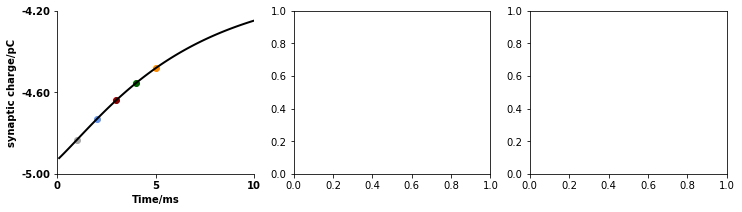

In [89]:
fig, ax2 = plt.subplots(1,3, figsize = (12,3.))
y1= np.exp(result_lambdas[0]*x)*result_multipliers[1]+np.exp(result_lambdas[1]*x)*result_multipliers[2] +result_multipliers[0] 
plot_curve(ax2[0], x, y1, color = 'black',
           title='' , xlim=[0,10],dx=5, ylim=[-5.,-4.2],dy=0.4, 
           alpha = 1.0, xlabel='Time/ms', ylabel = 'synaptic charge/pC', label='',
          nonscatter=True, s0=20, ynum_decimals=2)
color= ['darkgrey','cornflowerblue','darkred',
        'darkgreen','darkorange']
for i in range(5):
    ax2[0].scatter(x[i*10+9],y[i*10+9], color=color[i])

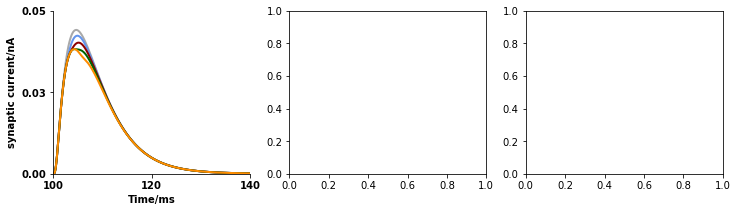

In [35]:
fig, ax2 = plt.subplots(1,3, figsize = (12,3.))
color= ['darkgrey','cornflowerblue','darkred',
        'darkgreen','darkorange']
for i in range(5):
    plot_curve(ax2[0], np.linspace(0,200,len(diff_I[i,:])), diff_I[i,:], color = color[i],
           title='' , xlim=[100,140],dx=20, ylim=[0,0.05],dy=0.025, 
           alpha = 1.0, xlabel='Time/ms', ylabel = 'synaptic current/nA', label='',
          nonscatter=True, s0=20, ynum_decimals=2)

# ax2[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
# ax2[1].axhline(y=5, color='black', linestyle='--', linewidth=2)

# $L\{\Gamma\}(x_E,x_S,0)$ caculation

In [2]:
def KES(passive = True):
    
    L5PC = h.L5PCtemplate(morphologyFilename)
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                # sec.gIhbar_Ih = 0.0002/20
                sec.gIhbar_Ih = 0.0
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.  
    # Set simulation parameters
    h.dt = 0.1
    h.tstop = 1000.
    # passive
    h.v_init = -90.
    v_clamp = -60.


    # # active
    # h.v_init = -88.
    # v_clamp = -55.

    recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
    v_dend82 = h.Vector().record(L5PC.dend[82](0.5)._ref_v)
    v_dend81 = h.Vector().record(L5PC.dend[81](0.5)._ref_v)
    
    # Initialize voltage clamp
    vclamp = h.SEClamp(L5PC.soma[0](0.5))
    vclamp.amp1 = v_clamp
    vclamp.dur1 = h.tstop
    vclamp.dur2 = h.tstop
    vclamp.dur3 = h.tstop
    vclamp.amp2 = v_clamp
    vclamp.amp3 = v_clamp

    irec = h.Vector()
    irec.record(vclamp._ref_i)


    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():

        vclamp.dur1 = 1.
        vclamp.dur2 = 1.
        vclamp.dur3 = 1.
        go()
        # v_rest = [seg.v for sec in h.allsec() for seg in sec]
        # vsoma_rest = recv.to_python()
        
        # vclamp.dur1 = h.tstop
        # vclamp.dur2 = h.tstop
        # go()
        # v_underclamp = [seg.v for sec in h.allsec() for seg in sec]
        # i = 0
        # K = np.zeros_like(v_rest)
        # for sec in h.allsec():
        #     for seg in sec:
        #         K[i] = (seg.v - v_rest[i])/(v_clamp - vsoma_rest[-1])
        #         i = i + 1
        # Gamma_SS = (v_clamp - vsoma_rest[-1])/irec.to_python()[-1]
        
        # only calculate KES in each section
        v_rest = [sec(0.5).v for sec in h.allsec()]
        vsoma_rest = recv.to_python()
        
        vclamp.dur1 = h.tstop
        vclamp.dur2 = h.tstop
        go()
        v_underclamp = [sec(0.5).v for sec in h.allsec()]
        i = 0
        K = np.zeros_like(v_rest)
        for sec in h.allsec():
            K[i] = (sec(0.5).v - v_rest[i])/(v_clamp - vsoma_rest[-1])
            i = i + 1
        Gamma_SS = (v_clamp - vsoma_rest[-1])/irec.to_python()[-1]
        
        return v_rest, v_underclamp, K, Gamma_SS
     
    v_rest, v_underclamp, K, Gamma_SS = main()

# np.savetxt('KE_passive.txt', KE_passive)
    return v_rest, v_underclamp, K, Gamma_SS


In [11]:
v_rest, v_underclamp, K_ES_passive_section, Gamma_SS = KES(passive = True)
print(v_rest)
print(v_underclamp)
print(Gamma_SS)

[-89.99999999942624, -89.99999999942665, -89.9999999994273, -89.99999999942932, -89.99999999942767, -89.99999999942847, -89.99999999942989, -89.99999999942895, -89.99999999942656, -89.99999999942695, -89.9999999994271, -89.99999999942763, -89.99999999942693, -89.99999999942736, -89.99999999943088, -89.99999999942882, -89.99999999942716, -89.99999999942645, -89.99999999942682, -89.99999999942717, -89.99999999942743, -89.99999999942735, -89.99999999942747, -89.99999999942781, -89.99999999942811, -89.99999999942816, -89.99999999942746, -89.99999999942838, -89.99999999942911, -89.99999999942997, -89.9999999994282, -89.99999999942892, -89.99999999943077, -89.99999999942963, -89.99999999942892, -89.99999999942693, -89.9999999994288, -89.99999999942793, -89.99999999942965, -89.99999999942882, -89.99999999942756, -89.99999999942897, -89.9999999994286, -89.9999999994267, -89.99999999942713, -89.99999999942791, -89.99999999942804, -89.99999999942719, -89.99999999942747, -89.99999999942801, -89.9

In [13]:
np.savetxt('K_ES_passive_section.txt', K_ES_passive_section)

# $L\{\Gamma\}(x_S,x_E,0)$ caculation

In [17]:
def KSE( v_rest, Gamma_SS, passive = True, vsoma_rest = -90.):
    
    L5PC = h.L5PCtemplate(morphologyFilename)
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                # sec.gIhbar_Ih = 0.0002/20
                sec.gIhbar_Ih = 0.0
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.  
    # Set simulation parameters
    h.dt = 0.1
    h.tstop = 1000.
    # passive
    h.v_init = -90.
    v_clamp = -60.


    # # active
    # h.v_init = -88.
    # v_clamp = -55.

    recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
    
    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
        
        KSE = []
        for section in h.allsec():
              # Initialize voltage clamp
            vclamp = h.SEClamp(section(1.0))
            vclamp.amp1 = v_clamp
            vclamp.dur1 = h.tstop
            vclamp.dur2 = h.tstop
            vclamp.dur3 = h.tstop
            vclamp.amp2 = v_clamp
            vclamp.amp3 = v_clamp

            irec = h.Vector()
            irec.record(vclamp._ref_i)
            go()
            vsoma = recv.to_python()
            KSE.append((vsoma[-1] - vsoma_rest)/irec.to_python()[-1]/Gamma_SS)
        
        
        return KSE
     
    KSE = main()

    return KSE

In [18]:
KSE_passive = KSE( v_rest= v_rest, Gamma_SS = Gamma_SS, passive = True, vsoma_rest = -90.)
np.savetxt('KSE_passive.txt', KSE_passive)

In [35]:
K_ES_passive = np.loadtxt('K_ES_passive_section.txt')
KSE_passive = np.loadtxt('KSE_passive.txt')
ratio_KSE_KES = KSE_passive/K_ES_passive
np.savetxt('ratio_KSE_KES.txt', ratio_KSE_KES)
print(ratio_KSE_KES)

[1.         0.99463322 0.99544853 0.99086399 0.99862835 0.99658548
 0.96775107 0.98956298 0.99588317 0.99851083 1.         0.99595827
 0.99832398 0.99586248 0.98067903 0.99156156 0.99843875 0.99668451
 0.99758967 0.99749466 1.         0.99984688 1.         0.9951769
 1.         1.         0.99294095 0.99357105 0.99811131 0.9826276
 0.99578412 0.99426134 0.99233267 0.99402582 0.99709751 0.99612823
 0.98391083 0.99036906 0.99480915 0.99706294 0.98461204 0.99773242
 1.         0.9965197  0.99775872 0.99352953 0.98217055 0.99607072
 0.99953651 0.99291806 1.         1.         0.9970907  0.99876141
 0.99546722 0.99559172 0.99903825 0.9975951  0.99746819 0.99299708
 0.99405051 0.9877379  0.99652155 0.99075576 0.99613171 0.99071785
 0.98967008 0.99125704 0.99561101 0.97418754 0.99063445 0.97575292
 0.99463405 0.96473267 0.99826141 0.98929119 0.99730962 0.99669228
 0.9980945  0.99956206 0.99878048 0.99637649 0.99809147 0.98363142
 1.         0.98607901 0.97263222 0.98868674 0.9858863  0.997498

In [30]:
print(np.min(ratio_KSE_KES),np.max(ratio_KSE_KES))

0.8693887079973818 1.000000000033836


In [34]:
print(ratio_KSE_KES[83])

0.9836314164207897
